# Keras Price Predictor - Paperspace

In [1]:
%load_ext autoreload
%autoreload 2

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from tqdm.notebook import trange, tqdm

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers.schedules import InverseTimeDecay
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

import wandb
from wandb.keras import WandbCallback
wandb.login()

from helpers import load_close_data, get_n_test_samples, \
                    repeat_evaluate, summarize_scores, train_and_validate

DOWNLOAD_DIR = Path('../download')
DATA_DIR = Path('../data')

sns.set()

wandb: Currently logged in as: theadammurphy (use `wandb login --relogin` to force relogin)


In [2]:
data = load_close_data(DOWNLOAD_DIR, dropna=True)
data.shape

(92192,)

# Manual LR Scheduling


RUN NUMBER 0



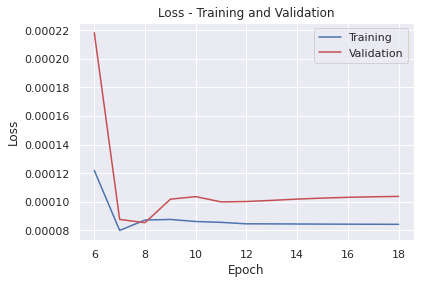

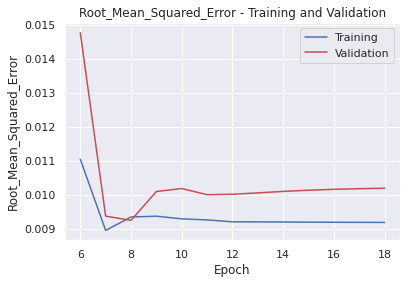

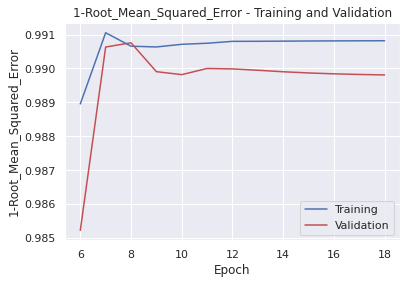

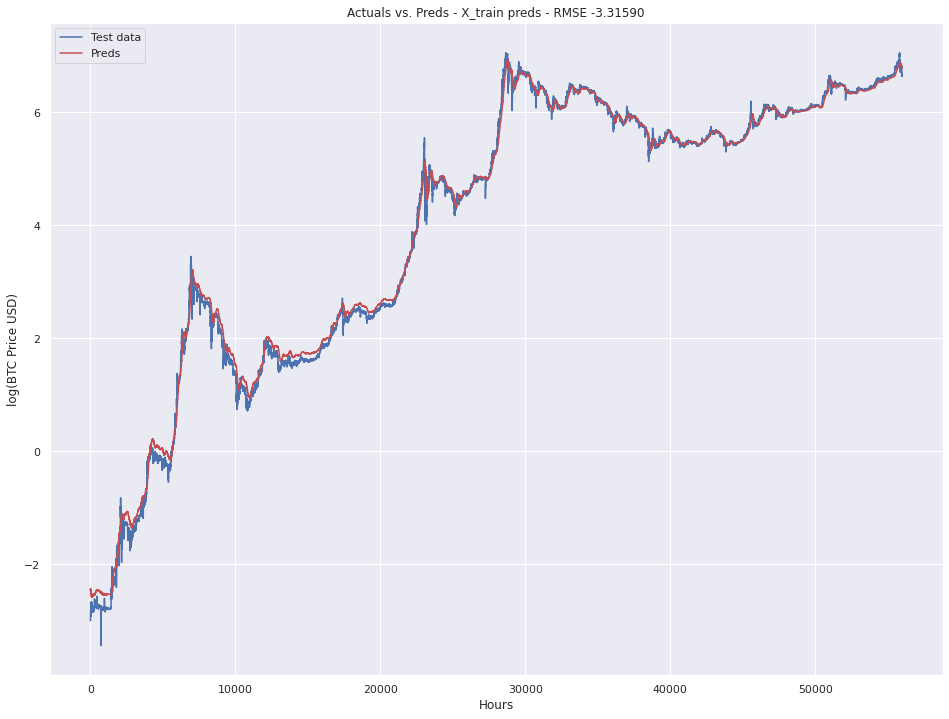

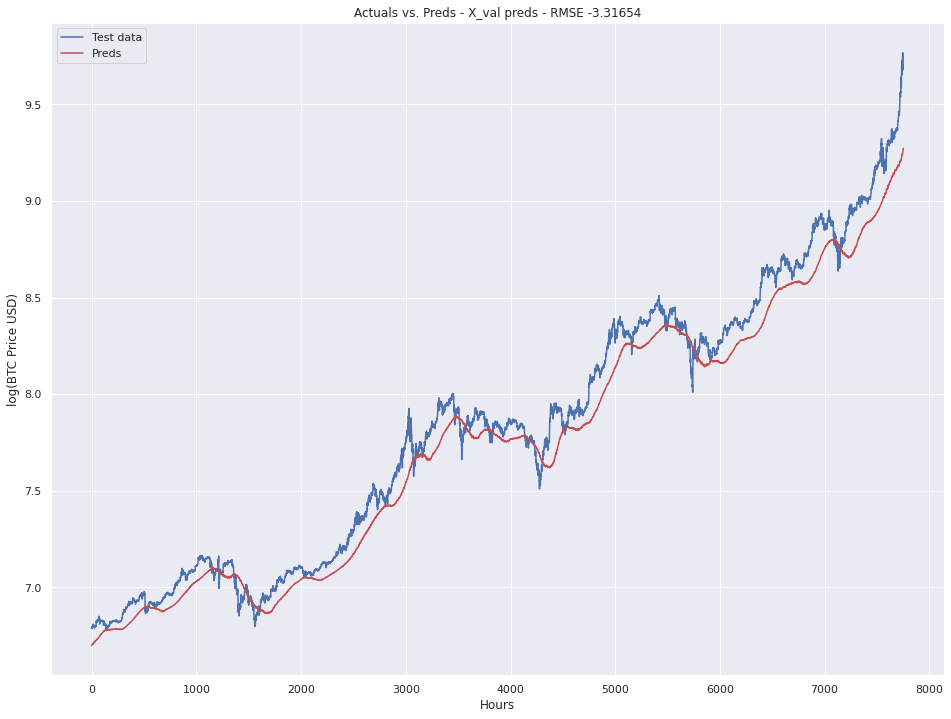

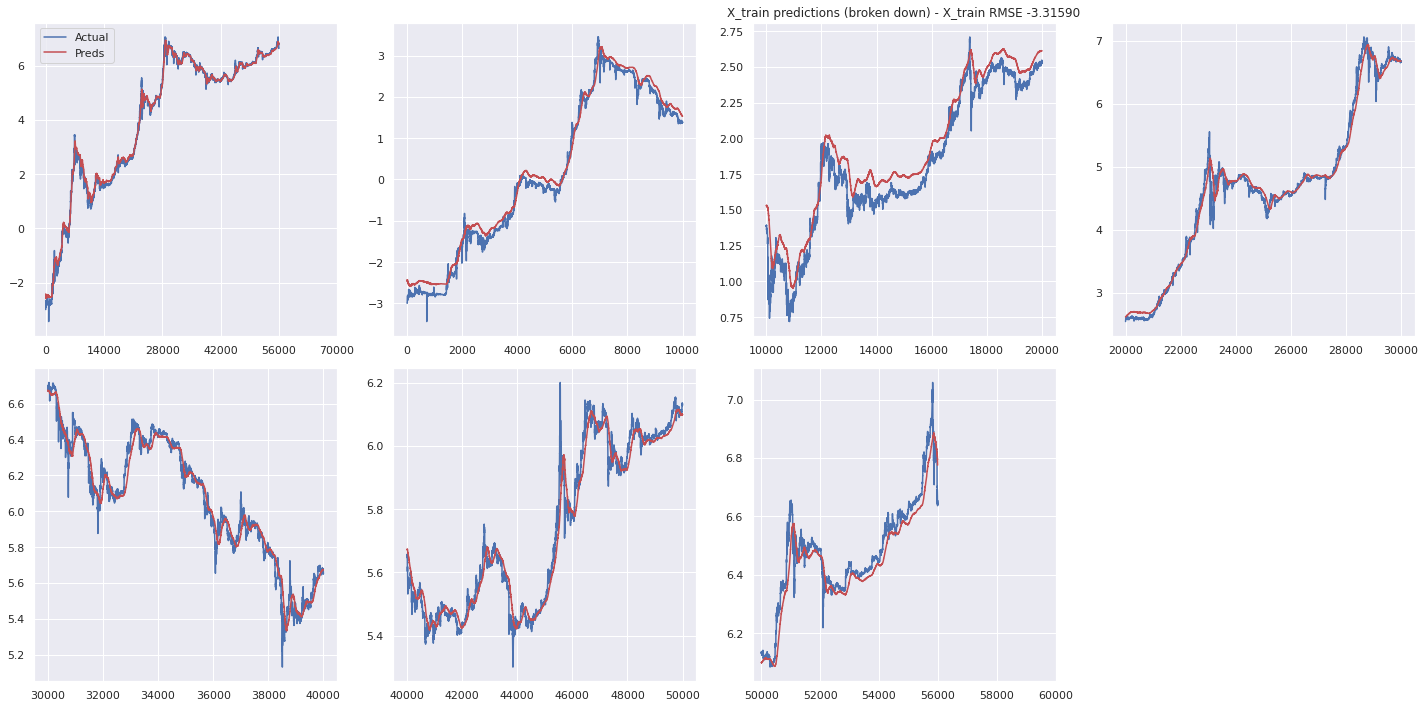

epoch,17
loss,8e-05
root_mean_squared_error,0.00918
val_loss,0.0001
val_root_mean_squared_error,0.01019
_runtime,17
_timestamp,1618469726
_step,24
best_val_loss,9e-05
best_epoch,7


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
root_mean_squared_error,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_root_mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▇▇█
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


In [6]:
for i in range(1):
    print(f'\nRUN NUMBER {i}\n')
    run = wandb.init(project='bitcoin_price_predictor',
                    config={
                        'dataset': 1,
                        # log, log_and_divide_a, log_and_range_a_b
                        'scaler': 'log_and_range_0_1',
                        'n_input': 168, # num lag observations
                        #'n_nodes': 300, # num nodes per lauyer
                        'n_epochs': 150, # num training epochs
                        'n_batch': 168 * 20, # batch size
                        #'num_layers': 3, # num layers used in MLP
                        'model_type': 'MLP',
                        'activation': 'relu',
                        'loss': 'mse',
                        # Model LR scheduler and optimizer
                        'use_lr_scheduler': False,
#                         'lr_scheduler': 'custom',
#                         'initial_lr': 1e-4,
                        'optimizer': 'adam',
                        'patience': 10,
                        'restore_best_weights': True,
                        'early_stopping_baseline': None, # set to None if there isn't one
                        # Other
                        'verbose': 0, # control verbosity of Keras fit
                        'dropna': True, # whether to drop missing values from data
                        'start_plotting_epoch': 5
                            })
    config = wandb.config # we use this to configure our experiment

    history = train_and_validate(config)
run.finish()

# LSTM


RUN NUMBER 0



epoch,5
loss,0.00937
root_mean_squared_error,0.09679
val_loss,0.02982
val_root_mean_squared_error,0.17269
_runtime,46
_timestamp,1618506466
_step,9
best_val_loss,0.02982
best_epoch,5


epoch,▁▂▄▅▇█
loss,█▃▁▁▁▁
root_mean_squared_error,█▄▂▁▁▁
val_loss,█▄▂▂▁▁
val_root_mean_squared_error,█▅▃▂▁▁
_runtime,▁▂▄▅▇█████
_timestamp,▁▂▄▅▇█████
_step,▁▂▃▃▄▅▆▆▇█


(55993, 168, 1) (7752, 168, 1) (55993,) (7752,)
Epoch 1/6
37/37 [==============================] - 12s 200ms/step - loss: 0.1428 - root_mean_squared_error: 0.3610 - val_loss: 0.3788 - val_root_mean_squared_error: 0.6154
Epoch 2/6
37/37 [==============================] - 6s 156ms/step - loss: 0.0563 - root_mean_squared_error: 0.2262 - val_loss: 0.1901 - val_root_mean_squared_error: 0.4360
Epoch 3/6
37/37 [==============================] - 6s 155ms/step - loss: 0.0188 - root_mean_squared_error: 0.1304 - val_loss: 0.1115 - val_root_mean_squared_error: 0.3339
Epoch 4/6
37/37 [==============================] - 6s 156ms/step - loss: 0.0257 - root_mean_squared_error: 0.1580 - val_loss: 0.0824 - val_root_mean_squared_error: 0.2871
Epoch 5/6
37/37 [==============================] - 6s 156ms/step - loss: 0.0281 - root_mean_squared_error: 0.1654 - val_loss: 0.0691 - val_root_mean_squared_error: 0.2629
Epoch 6/6
37/37 [==============================] - 6s 156ms/step - loss: 0.0241 - root_mean_squa

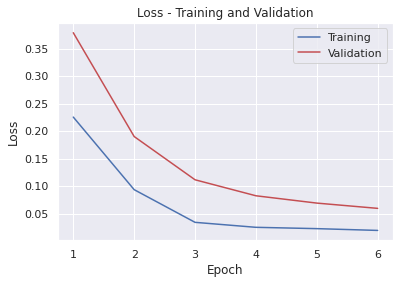

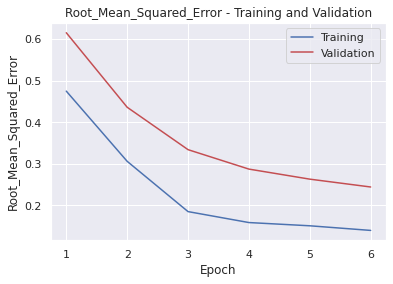

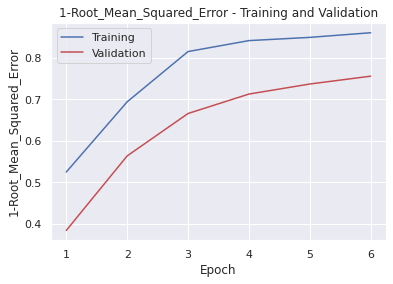

ValueError: Dimensions 37 and 55944 are not compatible

In [21]:
for i in range(1):
    print(f'\nRUN NUMBER {i}\n')
    run = wandb.init(project='bitcoin_price_predictor',
                    config={
                        'dataset': 1,
                        # log, log_and_divide_a, log_and_range_a_b
                        'scaler': 'log_and_range_0_1',
                        'n_input': 168, # num lag observations
                        #'n_nodes': 300, # num nodes per lauyer
                        'n_epochs': 6, # num training epochs
                        'n_batch': 168 * 9, # batch size
                        #'num_layers': 3, # num layers used in MLP
                        'model_type': 'LSTM',
                        'activation': 'relu',
                        'loss': 'mse',
                        ### Model LR scheduler and optimizer
                        'use_lr_scheduler': False,
#                         'lr_scheduler': 'custom',
#                         'initial_lr': 1e-4,
                        'lr': 1e-4, # if use_lr_scheduler == False
                        'optimizer': 'adam',
                        ### EarlyStopping callback ###
                        'patience': 10,
                        'restore_best_weights': True,
                        'early_stopping_baseline': None, # set to None if there isn't one
                        # Other
                        'verbose': 1, # control verbosity of Keras fit
                        'dropna': True, # whether to drop missing values from data
                        'start_plotting_epoch': 0
                            })
    config = wandb.config # we use this to configure our experiment

    history = train_and_validate(config)
run.finish()

In [9]:
from helpers import _measure_rmse

a = tf.data.Dataset.from_tensor_slices([0, 1, 2, 3, 4, 5])
b = np.array([5, 4, 1, 1, 5, 6])

In [18]:
_measure_rmse(list(a.), b)

AttributeError: 'TensorSliceDataset' object has no attribute 'as_numpy'

In [20]:
print(5 == 4)

False


In [10]:
from helpers import load_dataset_1, transform_to_keras_input

def print_shapes(vals):
    for val in vals:
        print(val.shape)

train, val, _ = load_dataset_1()
X_train, X_val, y_train, y_val = transform_to_keras_input(train, val, 200)

print_shapes([X_train, X_val, y_train, y_val])

(55961, 200)
(7720, 200)
(55961,)
(7720,)


In [14]:
for i in range(100, 410, 10):
    X_train, X_val, _, _ = transform_to_keras_input(train, val, i)
    print(X_train.shape, X_val.shape, X_train.shape[0] / i)

(56061, 100) (7820, 100) 560.61
(56051, 110) (7810, 110) 509.55454545454546
(56041, 120) (7800, 120) 467.0083333333333
(56031, 130) (7790, 130) 431.0076923076923
(56021, 140) (7780, 140) 400.15
(56011, 150) (7770, 150) 373.4066666666667
(56001, 160) (7760, 160) 350.00625
(55991, 170) (7750, 170) 329.3588235294118
(55981, 180) (7740, 180) 311.00555555555553
(55971, 190) (7730, 190) 294.5842105263158
(55961, 200) (7720, 200) 279.805
(55951, 210) (7710, 210) 266.43333333333334
(55941, 220) (7700, 220) 254.27727272727273
(55931, 230) (7690, 230) 243.1782608695652
(55921, 240) (7680, 240) 233.00416666666666
(55911, 250) (7670, 250) 223.644
(55901, 260) (7660, 260) 215.00384615384615
(55891, 270) (7650, 270) 207.0037037037037
(55881, 280) (7640, 280) 199.575
(55871, 290) (7630, 290) 192.65862068965518
(55861, 300) (7620, 300) 186.20333333333335
(55851, 310) (7610, 310) 180.16451612903225
(55841, 320) (7600, 320) 174.503125
(55831, 330) (7590, 330) 169.1848484848485
(55821, 340) (7580, 340) 1

In [16]:
55900 / 260

215.0

In [3]:
'lstm'.upper()

'LSTM'